### 1. Importing Libraries

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 2. Loading Data

In [2]:
data = pd.read_table('../data/u.data')

In [3]:
data.head()

,user,event,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Pre-processing the data

#### 3.1 Finding all unique values from data for events and users

In [4]:
users = data['user'].unique()
events = data['event'].unique()

events[:10], users[:10]

(array([242, 302, 377,  51, 346, 474, 265, 465, 451,  86]),
 array([196, 186,  22, 244, 166, 298, 115, 253, 305,   6]))

#### 3.2 Assigning idx's to unique users and events

In [5]:
user_to_idx = {user: idx for idx, user in enumerate(users)}
event_to_idx = {event: idx for idx, event in enumerate(events)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()} # For reverse lookup
idx_to_event = {idx: event for event, idx in event_to_idx.items()} # For reverse lookup

for key, value in user_to_idx.items():
    if value == 0:
        print(f'User: {key}, assigned index: {value}')

for key, value in event_to_idx.items():
    if value == 0:
        print(f'Event: {key}, assigned index: {value}')

User: 196, assigned index: 0
Event: 242, assigned index: 0


#### 3.3 Using the idx to add column in dataframe

In [6]:
data['user_idx'] = data['user'].map(user_to_idx)
data['event_idx'] = data['event'].map(event_to_idx)

data.head()

,user,event,rating,timestamp,user_idx,event_idx
0,196,242,3,881250949,0,0
1,186,302,3,891717742,1,1
2,22,377,1,878887116,2,2
3,244,51,2,880606923,3,3
4,166,346,1,886397596,4,4


#### 3.4 Splitting the data into training and testing

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=21, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=21, shuffle=True)
len(train_data), len(val_data), len(test_data)

(60000, 20000, 20000)

In [8]:
train_data.head()

,user,event,rating,timestamp,user_idx,event_idx
38585,519,878,5,884545961,521,995
57464,758,121,2,881978864,752,403
16125,277,872,3,879543768,261,223
16767,343,147,4,876402814,339,452
90032,686,50,4,879545413,684,357


In [9]:
test_data.head()

,user,event,rating,timestamp,user_idx,event_idx
39544,591,235,3,891039676,582,181
24258,450,689,3,882216026,442,890
23442,13,462,5,882140487,58,299
35853,159,1013,4,880557170,233,1013
35928,515,307,4,887659123,507,104


#### 3.5 Creating the train and test dataloaders

In [10]:
train_dataloader = DataLoader(train_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)

In [11]:
for batch in train_dataloader:
    print('Example batch: ', batch[:10])
    print()
    print('Len of a batch: ', len(batch))
    break

Example batch:  tensor([[ 529, 1200,    5],
        [ 847,   47,    2],
        [ 720,  158,    3],
        [ 927,  136,    5],
        [ 387,  684,    3],
        [  45,  452,    5],
        [ 590,  700,    2],
        [ 253,    9,    3],
        [ 128,   94,    5],
        [  65,  548,    3]])

Len of a batch:  64


### 4. Defining the model

In [12]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=96, hidden_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # RNN layers
        self.user_rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.item_rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, user, item):
        # Embedding lookups
        user_embedded = self.user_embedding(user).unsqueeze(1)  # Add sequence dimension
        item_embedded = self.item_embedding(item).unsqueeze(1)  # Add sequence dimension
        
        # Pass through RNNs
        _, user_hidden = self.user_rnn(user_embedded)
        _, item_hidden = self.item_rnn(item_embedded)
        
        # Concatenate RNN outputs
        x = torch.cat([user_hidden.squeeze(0), item_hidden.squeeze(0)], dim=-1)
        
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### 5. Defining the hyperparamters

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_users = len(users)
num_events = len(events)
model = NCF(num_users, num_events).to(device)
num_epochs = 10
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=10)

In [15]:
def train(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=10):
    train_losses = []
    val_losses = []
    train_mae = []
    val_mae = []
    train_rmse = []
    val_rmse = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        total_val_loss = 0
        total_mae = 0
        total_val_mae = 0

        # Training Loop
        for batch in train_dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            optimizer.zero_grad()
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(output - target)).item()

        # Validation Loop
        model.eval()  # Set the model to evaluation mode before validation
        with torch.no_grad():
            for batch in val_dataloader:
                user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
                output = model(user, event).squeeze()
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()
                total_val_mae += torch.mean(torch.abs(output - target)).item()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_train_mae = total_mae / len(train_dataloader)
        avg_val_mae = total_val_mae / len(val_dataloader)
        avg_train_rmse = np.sqrt(avg_train_loss)
        avg_val_rmse = np.sqrt(avg_val_loss)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_mae.append(avg_train_mae)
        val_mae.append(avg_val_mae)
        train_rmse.append(avg_train_rmse)
        val_rmse.append(avg_val_rmse)

        print(f'Epoch: {epoch+1} -> MSE Loss: {avg_train_loss} | RMSE Loss: {avg_train_rmse} | MAE: {avg_train_mae} | Val Loss: {avg_val_loss} | Val RMSE Loss: {avg_val_rmse} | Val MAE: {avg_val_mae}')

        if early_stopper.early_stop(avg_val_loss):
            break

    return train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse

In [16]:
train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs)

Epoch: 1 -> MSE Loss: 1.6092376871658032 | RMSE Loss: 1.268557325139784 | MAE: 0.9662076675815623 | Val Loss: 1.00621250624093 | Val RMSE Loss: 1.0031014436441261 | Val MAE: 0.8035314606782347
Epoch: 2 -> MSE Loss: 0.9673606085179965 | RMSE Loss: 0.9835449194205603 | MAE: 0.7839005974564217 | Val Loss: 0.9597323733015944 | Val RMSE Loss: 0.979659314915953 | Val MAE: 0.7819480871240171
Epoch: 3 -> MSE Loss: 0.9184774930543228 | RMSE Loss: 0.9583723144239522 | MAE: 0.7609560612930673 | Val Loss: 0.9364457951186184 | Val RMSE Loss: 0.9677012943665098 | Val MAE: 0.7661654583562296
Epoch: 4 -> MSE Loss: 0.8940194733043724 | RMSE Loss: 0.9455260299454332 | MAE: 0.7494968288997089 | Val Loss: 0.9500961118993668 | Val RMSE Loss: 0.9747287375979877 | Val MAE: 0.76547596496515
Epoch: 5 -> MSE Loss: 0.8765327859598436 | RMSE Loss: 0.936233296758796 | MAE: 0.7414759909674558 | Val Loss: 0.9305129424451639 | Val RMSE Loss: 0.9646309877073014 | Val MAE: 0.766931509247984
Epoch: 6 -> MSE Loss: 0.8569

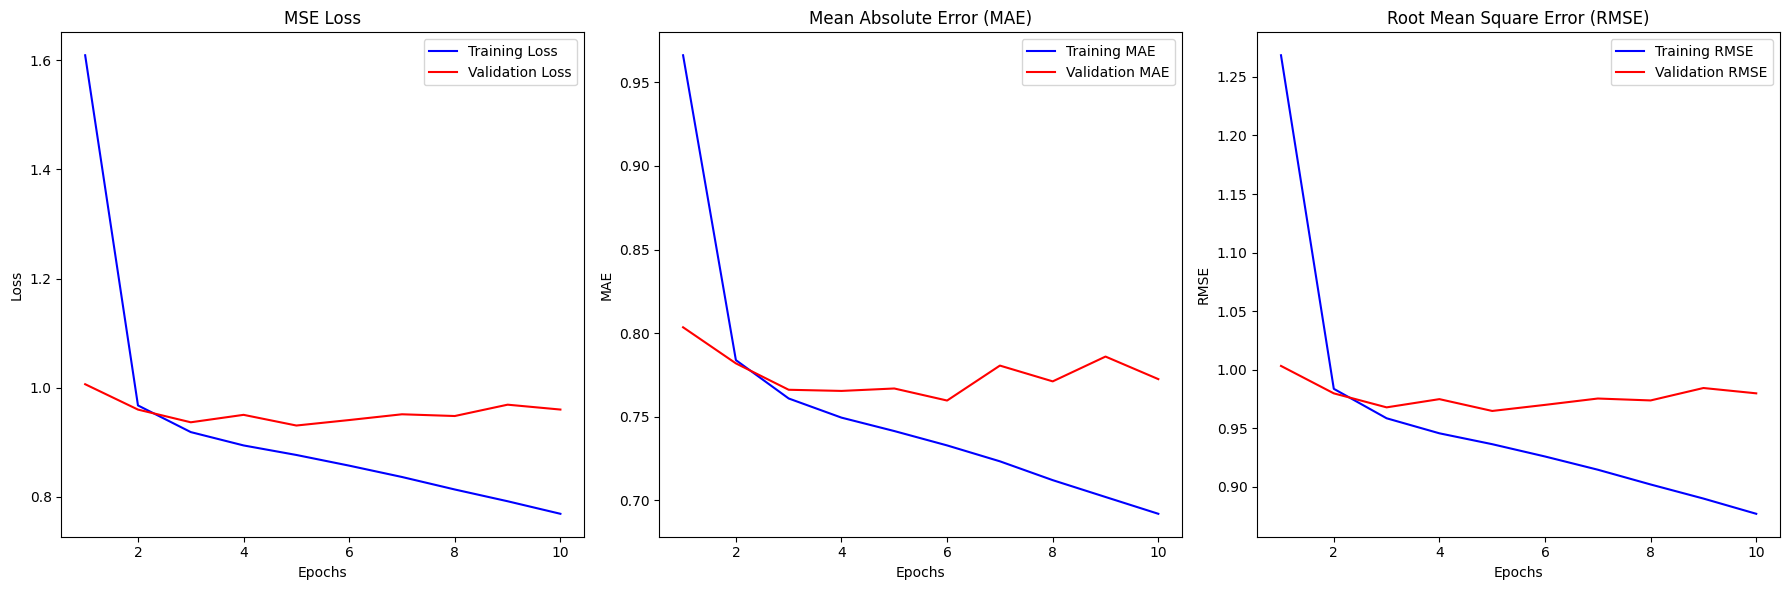

In [21]:
# Plotting
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 6))

# Plot Losses
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, train_mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse, 'b', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Root Mean Square Error (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
sample = [808, 881]
user = torch.tensor([user_to_idx[sample[0]]]).to(device)
event = torch.tensor([event_to_idx[sample[1]]]).to(device)
model.eval()
model(user, event)

tensor([[4.1460]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_mae = 0
    with torch.no_grad():
        for batch in dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(output - target)).item()
    
    avg_loss = total_loss / len(dataloader)
    avg_mae = total_mae / len(dataloader)
    avg_rmse = np.sqrt(avg_loss)
    
    print(f'Test MSE Loss: {avg_loss} | Test RMSE: {avg_rmse} | Test MAE: {avg_mae}')
    
    return avg_loss, avg_rmse, avg_mae

In [20]:
test_loss, test_rmse, test_mae = evaluate(model, test_dataloader, criterion, device)

Test MSE Loss: 0.949821580141878 | Test RMSE: 0.9745879027270337 | Test MAE: 0.7672696197375702
